## Cell type label transfer from reference dataset

T. J. Nowakowski et al., “Spatiotemporal gene expression trajectories reveal developmental hierarchies of  the human cortex.,” Science, vol. 358, no. 6368, pp. 1318–1323, Dec. 2017, doi: 10.1126/science.aap8809.

## Lasso Regression Model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import read_csv
from matplotlib import pyplot
import sklearn
import sklearn.linear_model
import matplotlib.pyplot as plt

import scanpy as sc

In [2]:
sc.set_figure_params('scanpy')

Reference dataset

In [3]:
NOWA = sc.read_h5ad('../Nowakowski-Science2017/write/processed_adata.h5ad')

In [4]:
NOWA.obs.cell_type

Cell
Hi_GW21_4.Hi_GW21_4    Glyc
Hi_GW21_5.Hi_GW21_5      RG
Hi_GW21_8.Hi_GW21_8      RG
Hi_GW21_1.Hi_GW21_1      EN
Hi_GW21_2.Hi_GW21_2      EN
                       ... 
S222.G8                  RG
S222.G9                   U
S222.H4                  RG
S222.H7                  RG
S222.H8                   U
Name: cell_type, Length: 4056, dtype: category
Categories (12, object): ['Astrocyte', 'Choroid', 'EN', 'Endothelial', ..., 'Mural', 'OPC', 'RG', 'U']

HiQ

In [5]:
processed_adata = './write/all_adata_processed.h5ad'

In [6]:
HiQ = sc.read_h5ad(processed_adata)

**Nowakoski to HiQ**

In [7]:
genes = np.intersect1d(NOWA.var_names, HiQ.var_names)
genes.shape

(16777,)

In [8]:
X_nowa = pd.DataFrame(NOWA.X, columns=NOWA.var_names)[genes].values

In [9]:
X_HiQ = pd.DataFrame(HiQ.X, columns=HiQ.var_names)[genes].values

In [10]:
y_nowa = pd.get_dummies(NOWA.obs.cell_type)
y_nowa

,Astrocyte,Choroid,EN,Endothelial,Glyc,IN,IPC,Microglia,Mural,OPC,RG,U
Cell,,,,,,,,,,,,
Hi_GW21_4.Hi_GW21_4,0,0,0,0,1,0,0,0,0,0,0,0
Hi_GW21_5.Hi_GW21_5,0,0,0,0,0,0,0,0,0,0,1,0
Hi_GW21_8.Hi_GW21_8,0,0,0,0,0,0,0,0,0,0,1,0
Hi_GW21_1.Hi_GW21_1,0,0,1,0,0,0,0,0,0,0,0,0
Hi_GW21_2.Hi_GW21_2,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
S222.G8,0,0,0,0,0,0,0,0,0,0,1,0
S222.G9,0,0,0,0,0,0,0,0,0,0,0,1
S222.H4,0,0,0,0,0,0,0,0,0,0,1,0


Test Hyperparameter lambda

In [11]:
# define model
model = sklearn.linear_model.Lasso(alpha=0.1)
# define model evaluation method
cv = sklearn.model_selection.RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = sklearn.model_selection.cross_val_score(model, X_nowa, y_nowa, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)


In [12]:
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean MAE: 0.075 (0.001)


In [13]:
# fit model
model.fit(X_nowa, y_nowa)

Lasso(alpha=0.1)

In [14]:
pred_cell_type=[]

In [15]:
i = 0
for row in X_HiQ:
    # make a prediction
    yhat = model.predict([row])
    
    # label of max pred score
    pred_cell_type.append(y_nowa.columns[yhat[0][:-1].argmax()])
    
#     # summarize prediction with binary prediction
#     pred = (yhat == yhat.max(axis=1)[:,None]).astype(int)
    
#     # Cluster label
#     truth = HiQ.obs.iloc[i,:]['leiden']
    
#     # Update hits table
#     sum_hits.loc[truth] = sum_hits.loc[truth].values+pred
    
    i=i+1

In [16]:
HiQ.obs['pred_cell_type']=pred_cell_type

In [17]:
sc.tl.rank_genes_groups(HiQ, 'pred_cell_type', method='t-test_overestim_var', key_added='t-test_overestim_var_pred')
sc.tl.rank_genes_groups(HiQ, 'pred_cell_type', method='wilcoxon', key_added='wilcoxon_pred')


/group/crtd_bergmann/Giovanni/python=3.9/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'pred_cell_type' as categorical


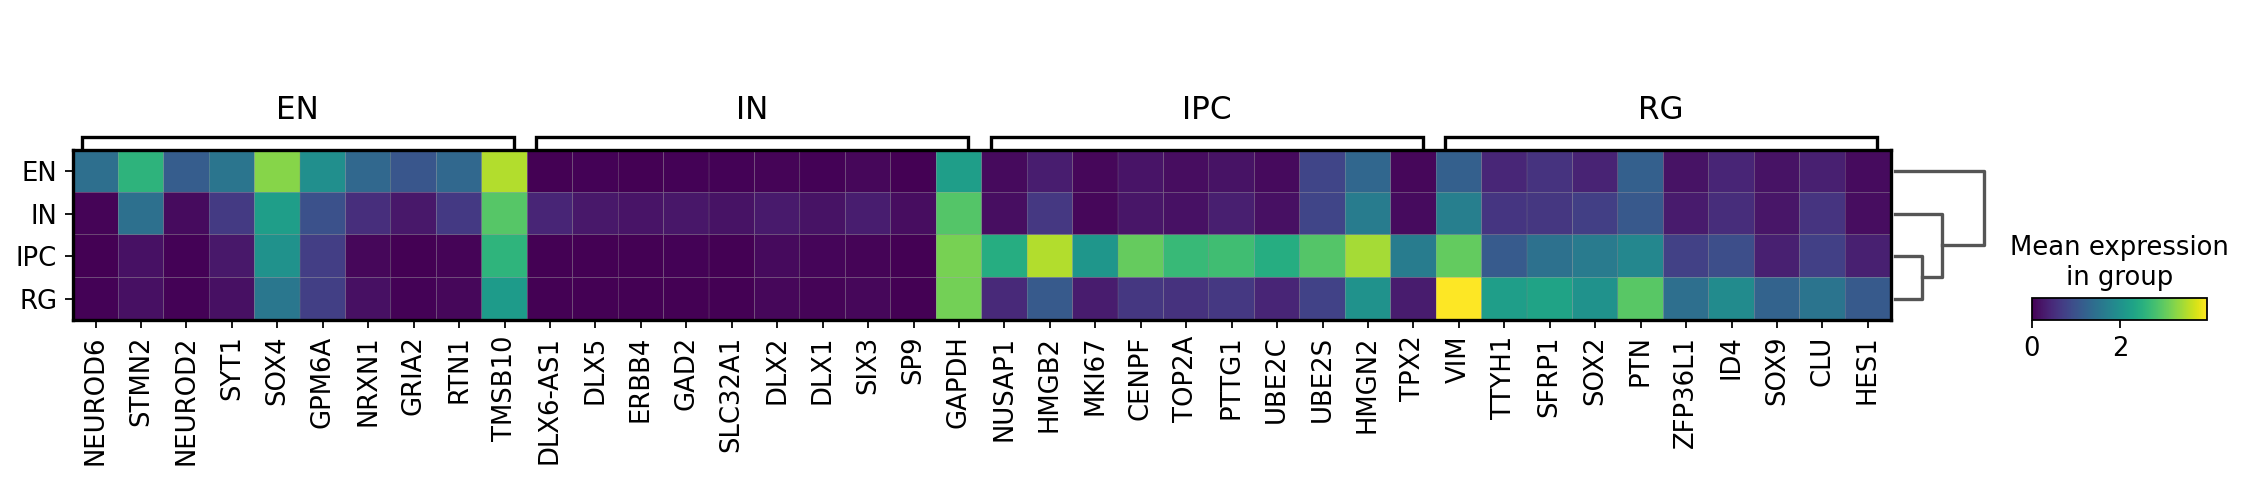

In [18]:
ax = sc.pl.rank_genes_groups_matrixplot(HiQ, #n_genes = 2,
                                            key='t-test_overestim_var_pred',
                                            swap_axes = False
                                           )

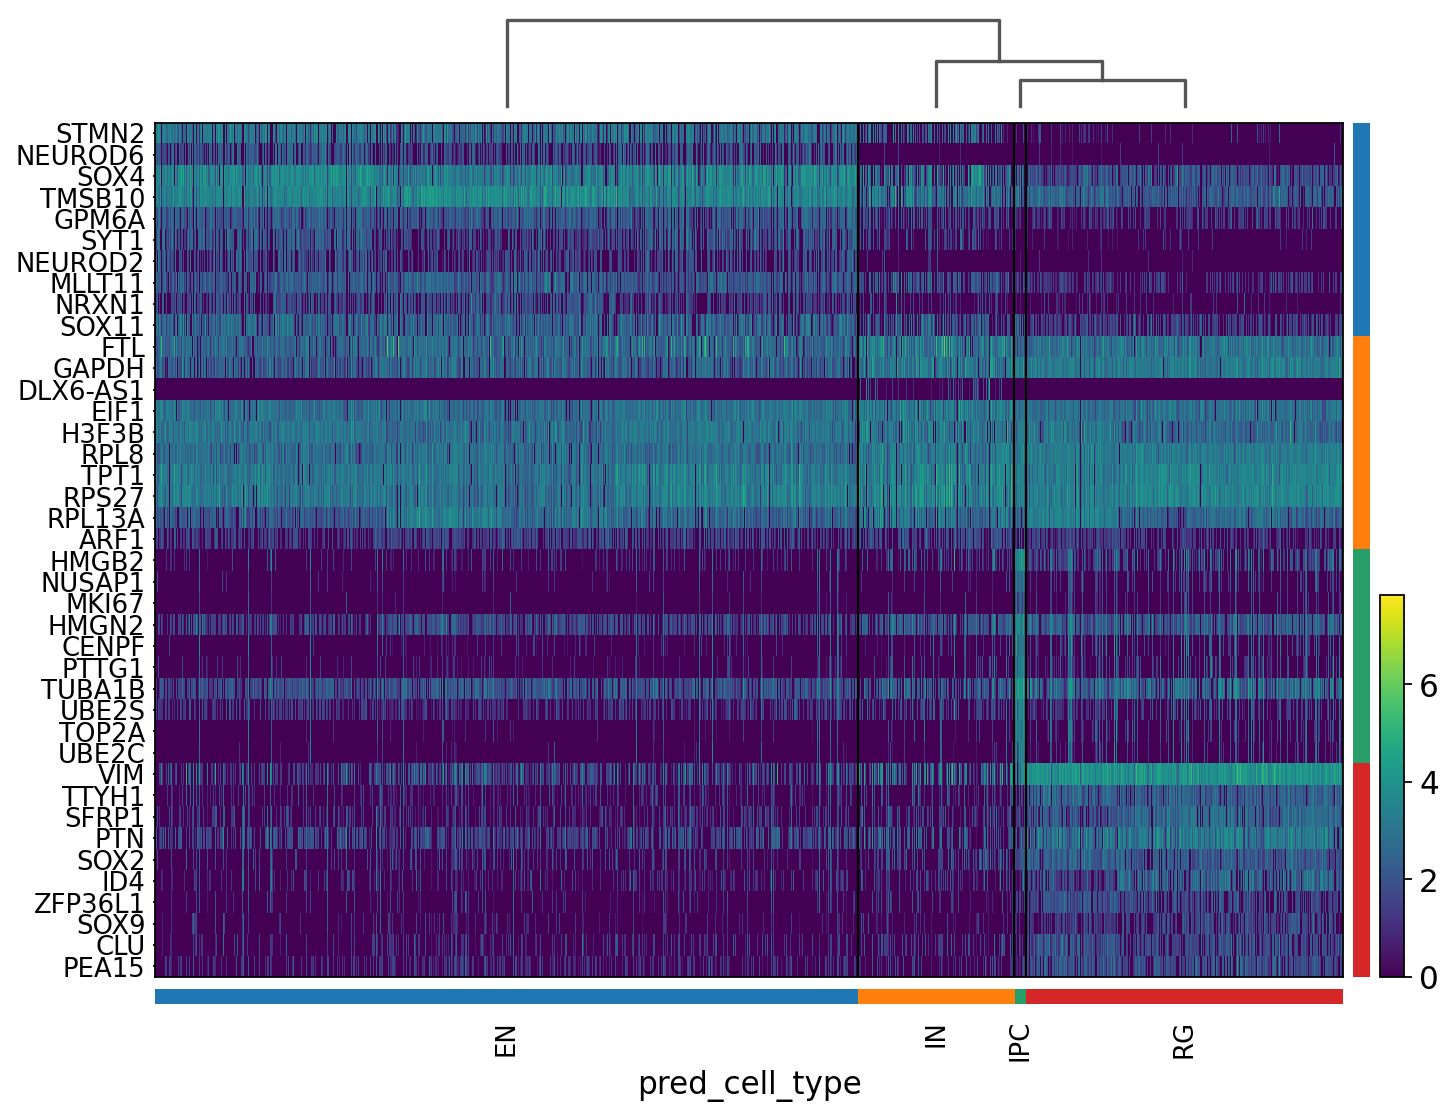

In [19]:
ax = sc.pl.rank_genes_groups_heatmap(HiQ, #n_genes = 2,
                                            key='wilcoxon_pred',
                                            swap_axes = True
                                           )

In [20]:
anno_dict = {
'Neuron': ['DCX','STMN2'],
'Exc': ['SLC17A7','SATB2','NEUROD2','EMX1'],
'Inh': ['GAD2','GAD1','SIX3','DLX6-AS1','DLX1','DLX2','DLX5','SCGN','ISL1'],
'IPC': ['EOMES',"NHLH1",],
'proRG': ['MKI67', 'CENPF', 'TOP2A', 'NUSAP1'],
'Astrocyte': ['S100B','GFAP','AQP4','ID3','IL33','GJA1'],
'Oligo': ['SOX6','NAGLU','GALC','OLIG1','OLIG2','PLP1'],
'Glia': ['TTYH1','SOX2','PAX6','HES1','GLI3'],

}

categories: EN, IN, IPC, etc.
var_group_labels: Neuron, Exc, Inh, etc.


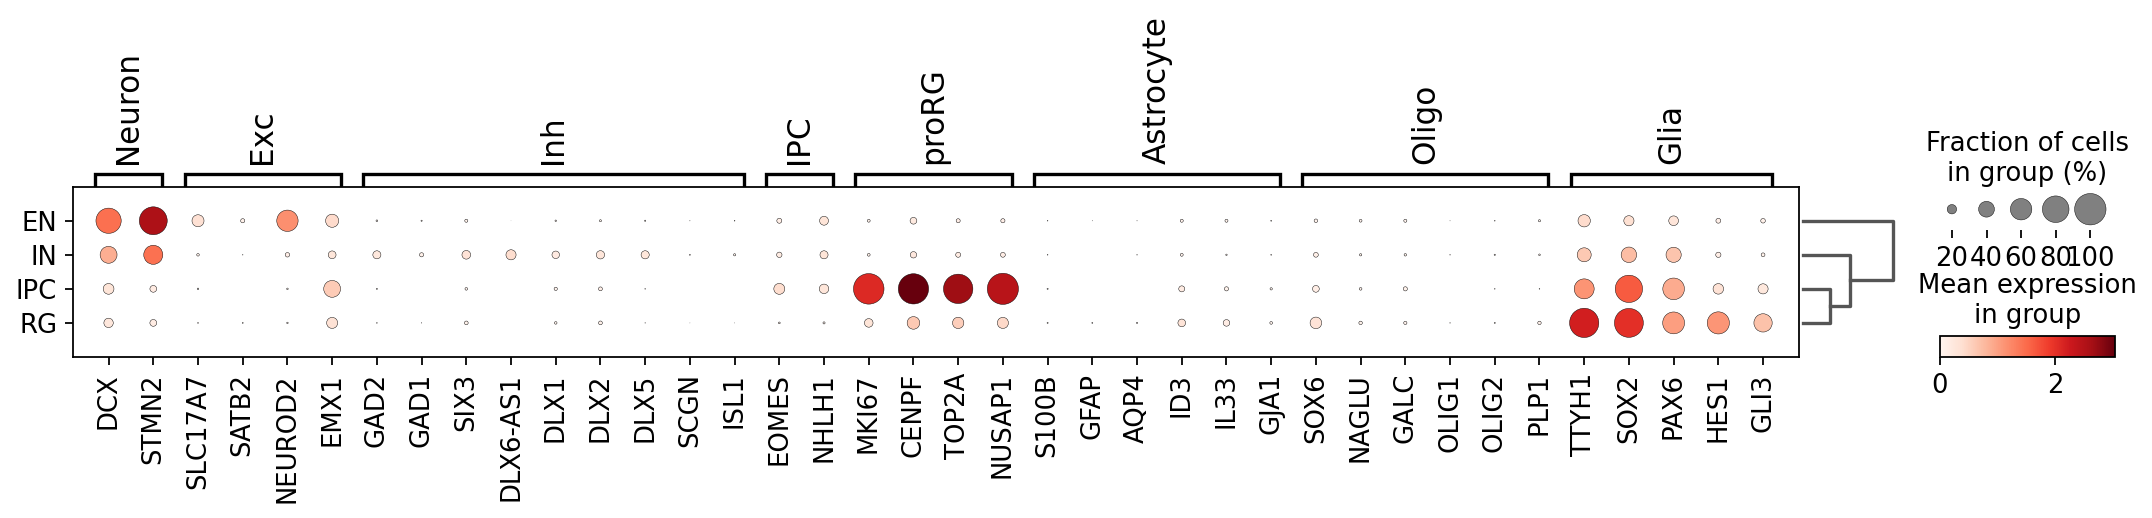

In [21]:
sc.pl.dotplot(HiQ, anno_dict,
              ['pred_cell_type'],
              dendrogram=True,
              swap_axes=False,
#               cmap='viridis'
#               rotation= 90
#               cmap=mymap
#               save='_OpticChiasmFULL.pdf'
             )


In [22]:
HiQ.write('./write/all_adata_labeled.h5ad')